In [1]:
import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import sweetviz

from sklearn.model_selection import train_test_split
from nflows.distributions import ConditionalDiagonalNormal

from src.probabilistic_flow_boosting.tfboost.tree import EmbeddableCatBoostPriorNormal
from src.probabilistic_flow_boosting.tfboost.tfboost import TreeFlowBoost
from src.probabilistic_flow_boosting.tfboost.flow import ContinuousNormalizingFlow
from src.probabilistic_flow_boosting.pipelines.reporting.nodes import calculate_nll

from src.probabilistic_flow_boosting.pipelines.modeling.utils import setup_random_seed

RANDOM_SEED = 42

setup_random_seed(RANDOM_SEED)

/opt/conda/lib/python3.6/site-packages/sweetviz/config.py:14: DeprecationWarning: open_text is deprecated. Use files() instead. Refer to https://importlib-resources.readthedocs.io/en/latest/using.html#migrating-from-legacy for migration advice.
  the_open = pkg_resources.open_text("sweetviz", 'sweetviz_defaults.ini')


In [2]:
df = pd.read_csv('data/01_raw/CatData/wine_reviews/winemag-data_first150k.csv', index_col=0)
df['country'] = df['country'].fillna('')
df['province'] = df['province'].fillna('')
df = df.dropna(subset = ['price'])

                                             |          | [  0%]   00:00 -> (? left)


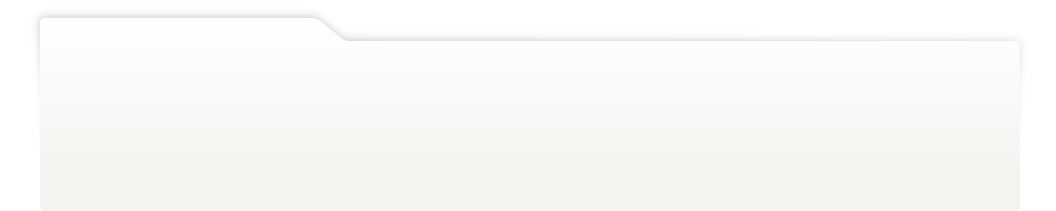
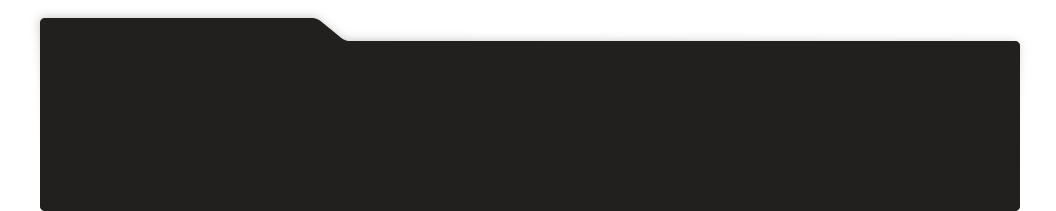
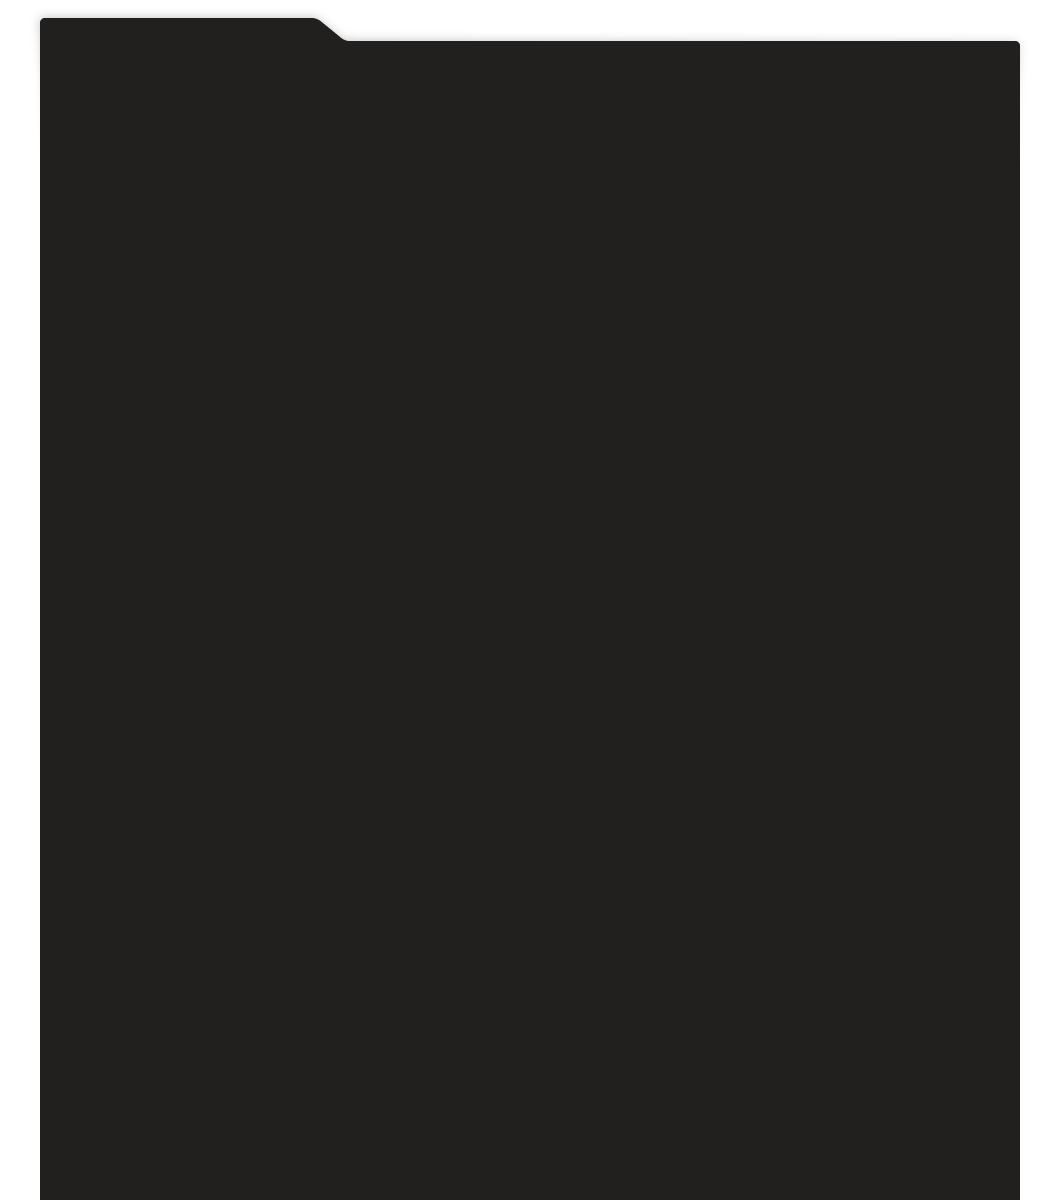
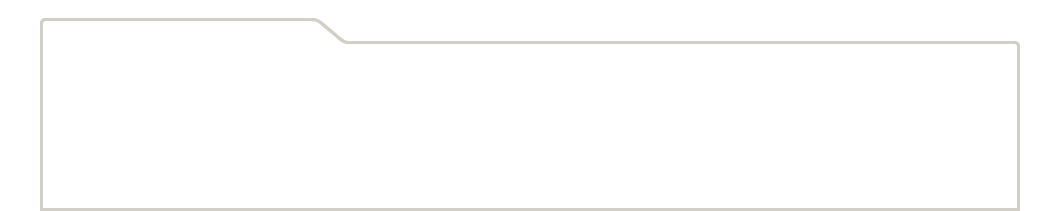
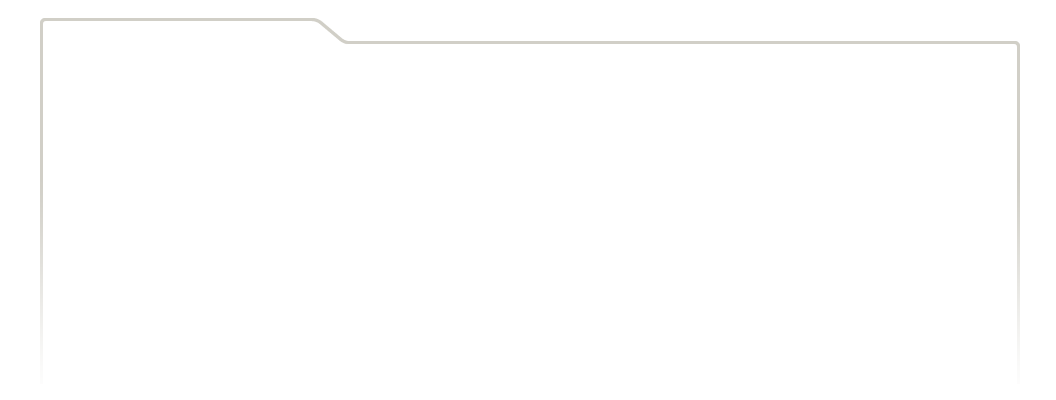
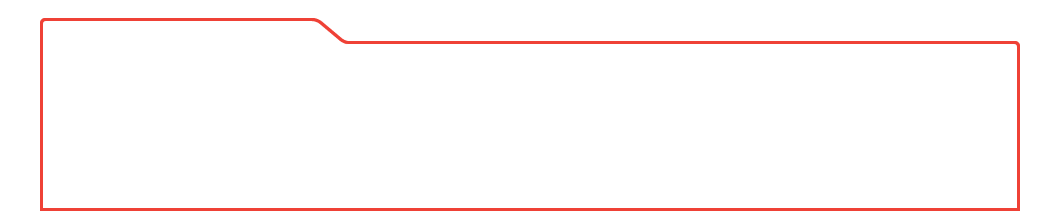
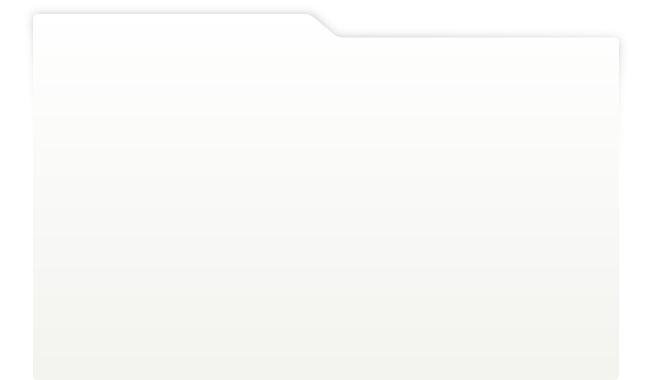
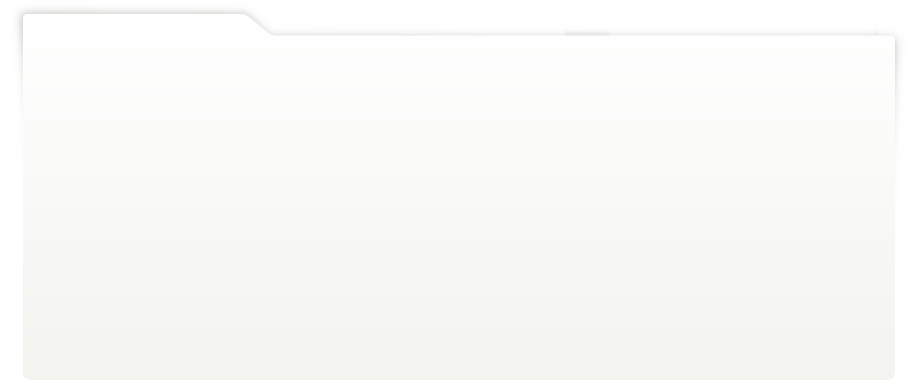
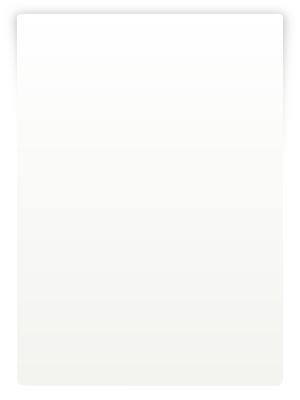
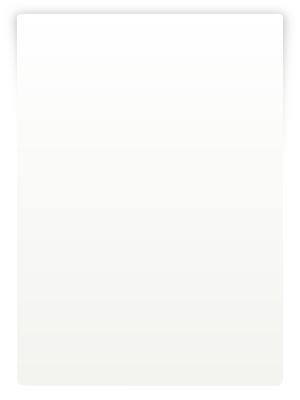
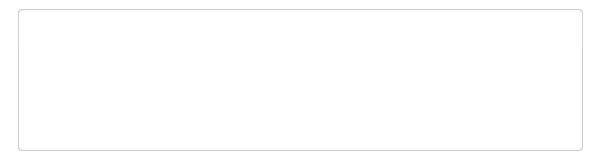
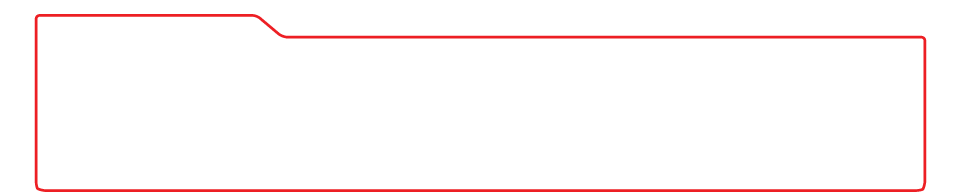
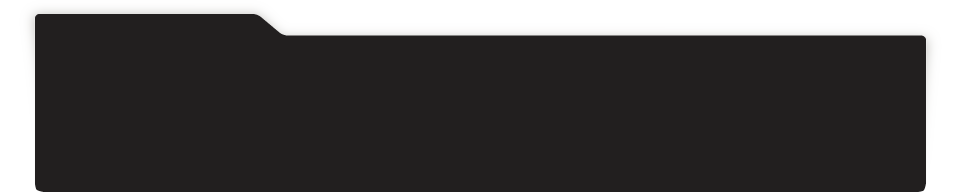
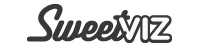
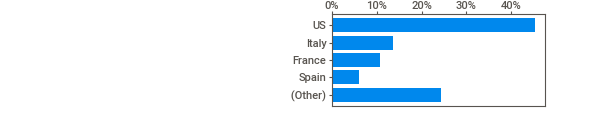
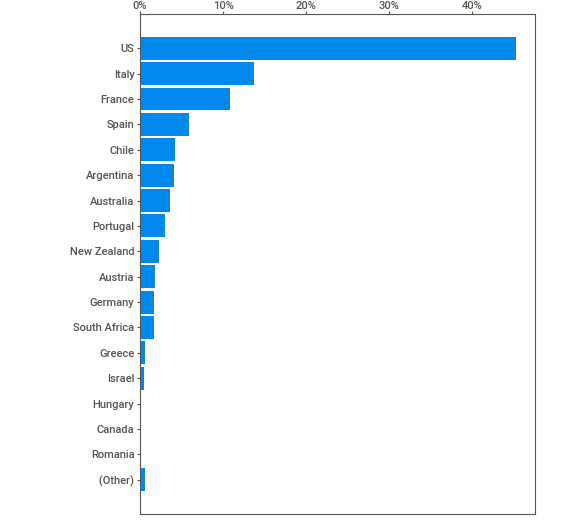
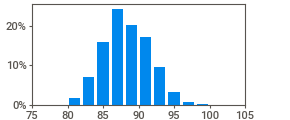
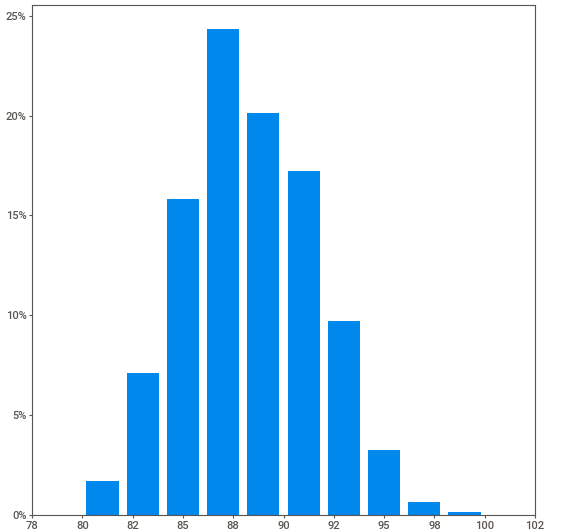
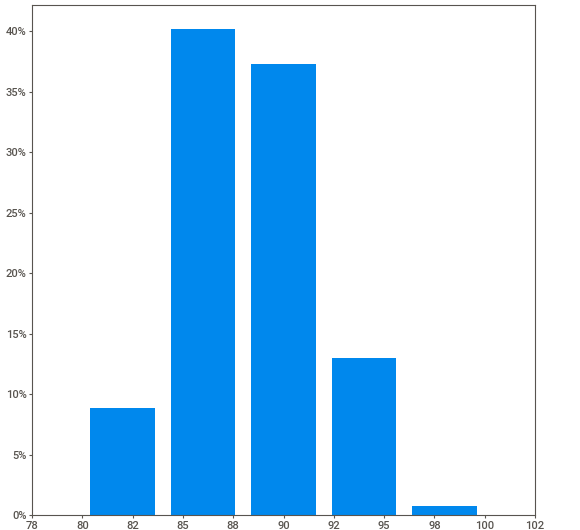
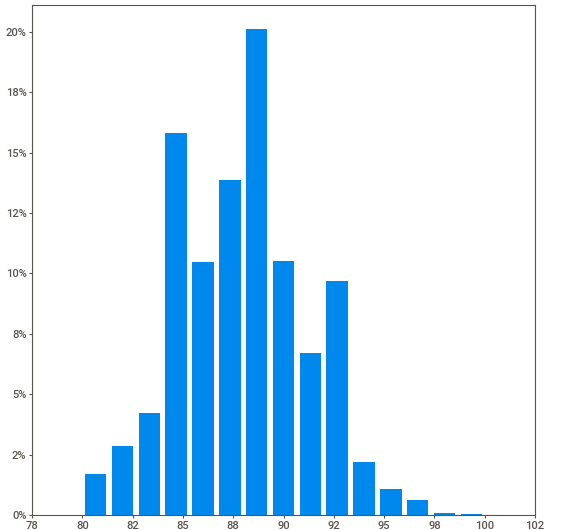
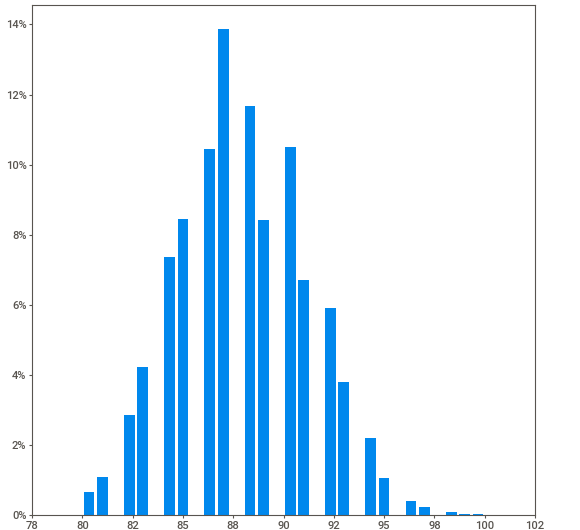
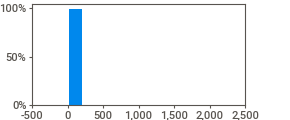
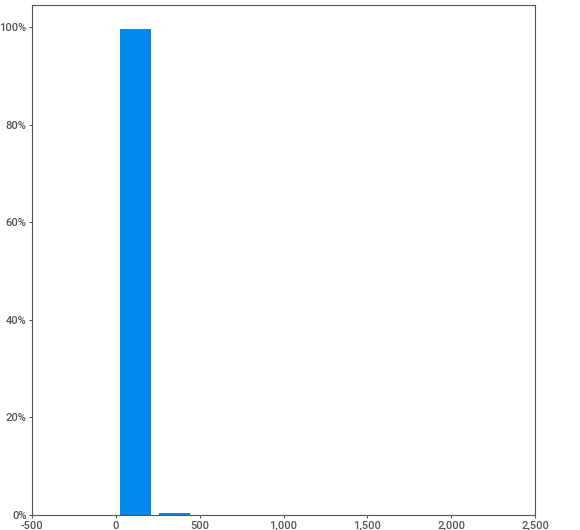
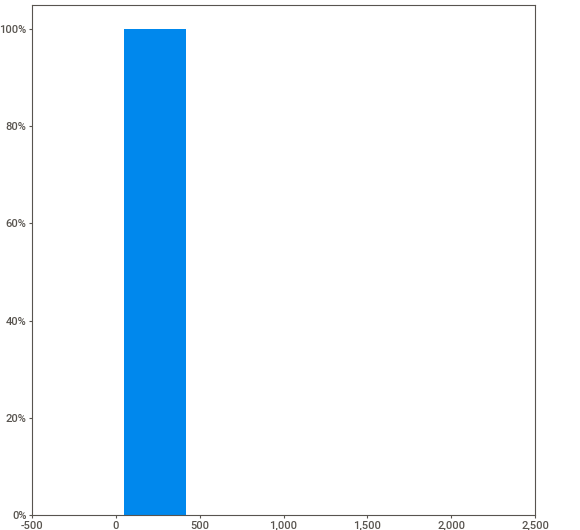
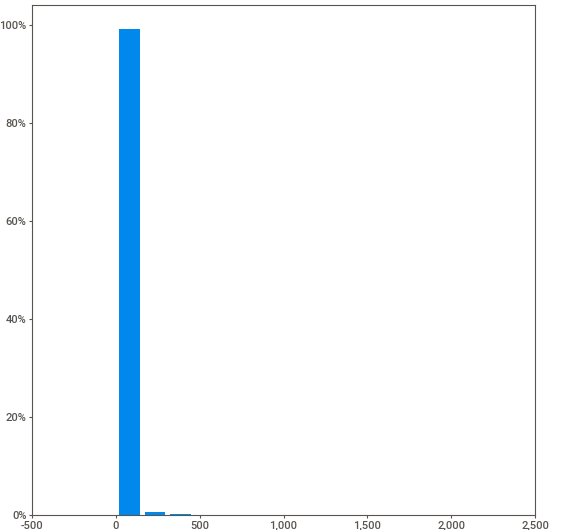
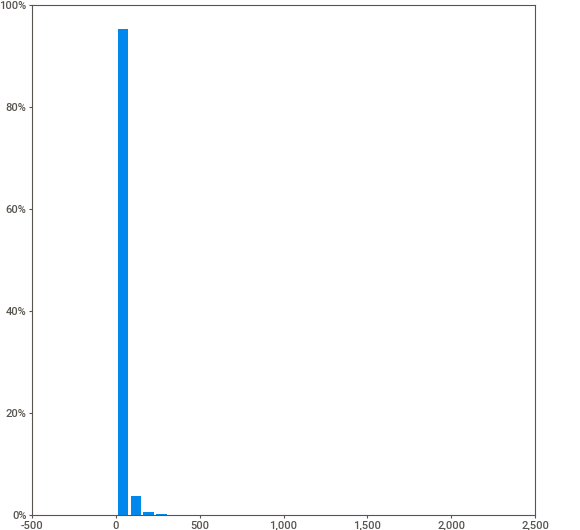
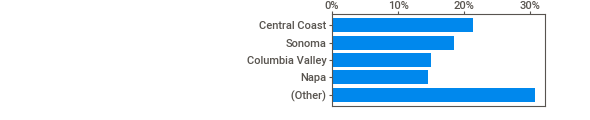
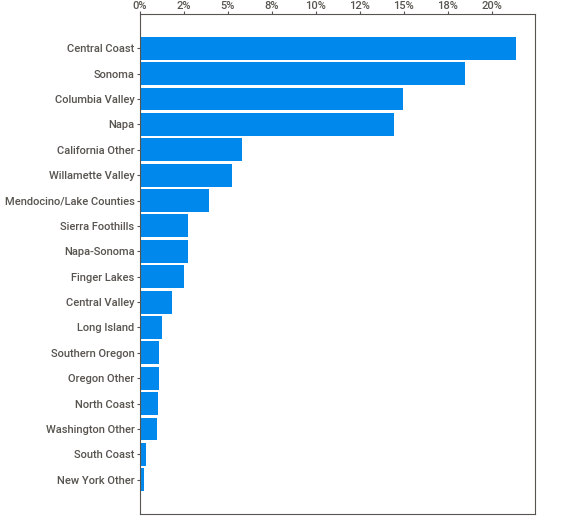
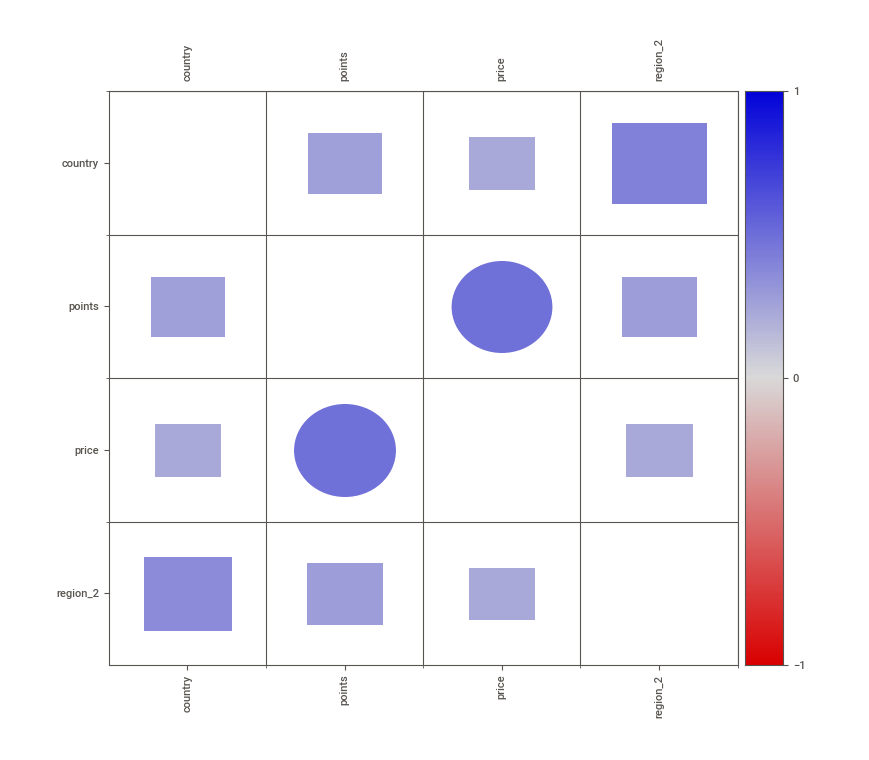
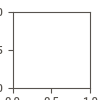

In [3]:
analysis = sweetviz.analyze(df)
analysis.show_notebook()

In [4]:
x = df.drop(columns = ['description', 'price', 'designation', 'region_1', 'region_2', 'winery'])
y = df[['price']]

In [5]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137235 entries, 0 to 150929
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   country   137235 non-null  object
 1   points    137235 non-null  int64 
 2   province  137235 non-null  object
 3   variety   137235 non-null  object
dtypes: int64(1), object(3)
memory usage: 5.2+ MB


In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=42)
x_tr, x_val, y_tr, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=42)

In [7]:
x_train.shape, x_test.shape

((109788, 4), (27447, 4))

In [8]:
model = catboost.CatBoostRegressor(
    cat_features=['country', 'province', 'variety'], 
    loss_function="RMSEWithUncertainty",
)

In [9]:
model.fit(x_tr, y_tr, eval_set=(x_val, y_val))

0:	learn: 4.8314372	test: 4.8292271	best: 4.8292271 (0)	total: 67.7ms	remaining: 1m 7s
1:	learn: 4.7997077	test: 4.7939343	best: 4.7939343 (1)	total: 87ms	remaining: 43.4s
2:	learn: 4.7757775	test: 4.7673830	best: 4.7673830 (2)	total: 103ms	remaining: 34.3s
3:	learn: 4.7574390	test: 4.7478932	best: 4.7478932 (3)	total: 116ms	remaining: 28.8s
4:	learn: 4.7397537	test: 4.7287857	best: 4.7287857 (4)	total: 130ms	remaining: 25.9s
5:	learn: 4.7234768	test: 4.7114356	best: 4.7114356 (5)	total: 150ms	remaining: 24.9s
6:	learn: 4.7081416	test: 4.6953868	best: 4.6953868 (6)	total: 164ms	remaining: 23.3s
7:	learn: 4.6938546	test: 4.6804105	best: 4.6804105 (7)	total: 175ms	remaining: 21.6s
8:	learn: 4.6806698	test: 4.6664630	best: 4.6664630 (8)	total: 189ms	remaining: 20.8s
9:	learn: 4.6679297	test: 4.6531908	best: 4.6531908 (9)	total: 201ms	remaining: 19.9s
10:	learn: 4.6556153	test: 4.6400570	best: 4.6400570 (10)	total: 215ms	remaining: 19.3s
11:	learn: 4.6443701	test: 4.6279899	best: 4.6279899

In [10]:
def calculate_nll_catboost(model: catboost.CatBoostRegressor, x: pd.DataFrame, y: pd.DataFrame):
    x: np.ndarray = x.values
    y: np.ndarray = y.values

    if y.shape[1] > 1:
        return np.nan

    y_hat_tree = model.predict(x)
    y_hat_tree[:, 1] = np.log(np.sqrt(y_hat_tree[:, 1]))  # Transform var to log std / CatBoost RMSEWithUncertainty

    distribution = ConditionalDiagonalNormal(shape=[1])  # Assume 1D distribution
    return -distribution.log_prob(y, y_hat_tree).numpy().mean()

In [11]:
calculate_nll_catboost(model, x_train, y_train)

4.003470702802556

In [12]:
calculate_nll_catboost(model, x_test, y_test)

4.029862609470571

In [13]:
tree = EmbeddableCatBoostPriorNormal(
    cat_features=[0, 2, 3], 
    loss_function="RMSEWithUncertainty",
    depth=3,
    num_trees=100,
    random_state=RANDOM_SEED
)
flow = ContinuousNormalizingFlow(input_dim=1, hidden_dims=(100, 100, 50), context_dim=100, conditional=True)

treeflow = TreeFlowBoost(tree, flow, embedding_size=100)

In [14]:
treeflow.fit(x_tr.values, y_tr.values, x_val.values, y_val.values, n_epochs=10, batch_size=2048, verbose=True)

0:	learn: 4.8545150	total: 7.99ms	remaining: 791ms
1:	learn: 4.8203797	total: 13.1ms	remaining: 642ms
2:	learn: 4.7979336	total: 18ms	remaining: 583ms
3:	learn: 4.7736525	total: 25.3ms	remaining: 608ms
4:	learn: 4.7526983	total: 31.3ms	remaining: 595ms
5:	learn: 4.7383686	total: 36.5ms	remaining: 572ms
6:	learn: 4.7233227	total: 41.5ms	remaining: 551ms
7:	learn: 4.7080362	total: 46.8ms	remaining: 538ms
8:	learn: 4.6954729	total: 51.9ms	remaining: 525ms
9:	learn: 4.6834125	total: 57.9ms	remaining: 521ms
10:	learn: 4.6723955	total: 62.9ms	remaining: 509ms
11:	learn: 4.6619876	total: 67.9ms	remaining: 498ms
12:	learn: 4.6496374	total: 72.8ms	remaining: 487ms
13:	learn: 4.6382801	total: 77.7ms	remaining: 477ms
14:	learn: 4.6275176	total: 83ms	remaining: 470ms
15:	learn: 4.6169598	total: 88ms	remaining: 462ms
16:	learn: 4.6069891	total: 93ms	remaining: 454ms
17:	learn: 4.5998598	total: 98ms	remaining: 446ms
18:	learn: 4.5909147	total: 103ms	remaining: 439ms
19:	learn: 4.5823819	total: 108ms

TreeFlowBoost(embedding_size=100,
              flow_model=<src.probabilistic_flow_boosting.tfboost.flow.flow.ContinuousNormalizingFlow object at 0x7f6a102d82b0>,
              tree_model=<src.probabilistic_flow_boosting.tfboost.tree.ecatboost.EmbeddableCatBoostPriorNormal object at 0x7f6a102d80f0>)

In [15]:
calculate_nll(treeflow, x_train, y_train, batch_size = 1024)

3.8480942

In [16]:
calculate_nll(treeflow, x_test, y_test, batch_size = 1024)

3.811703

In [17]:
data = x_test.iloc[:10, :]

In [18]:
y_test_catboost = model.predict(data)

y_test_samples = treeflow.sample(data, num_samples=1000)
y_test_samples = y_test_samples.squeeze()

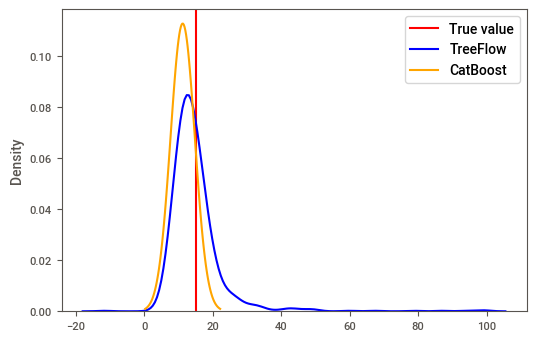

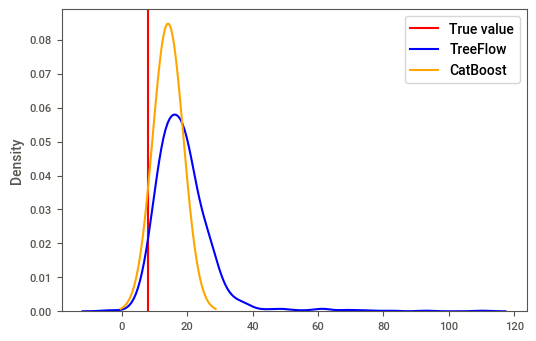

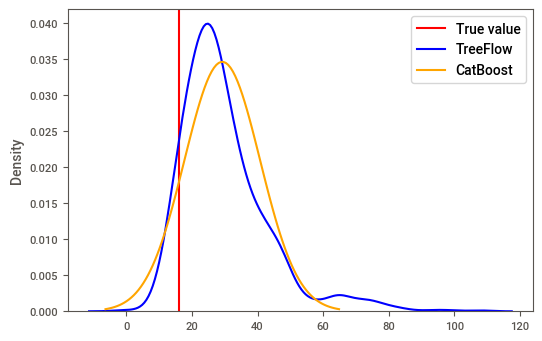

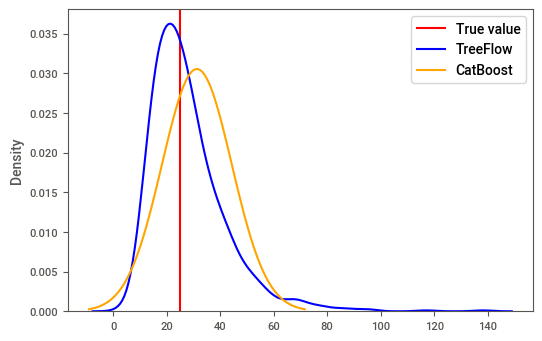

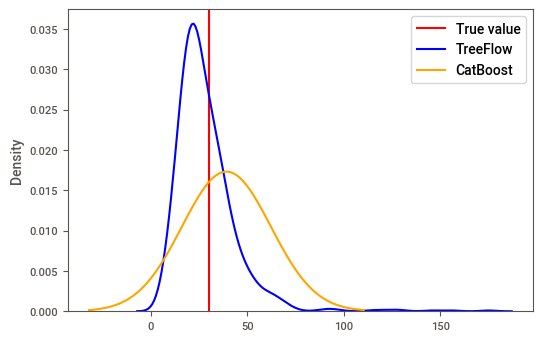

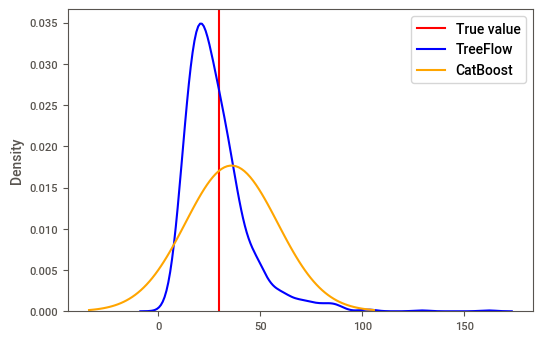

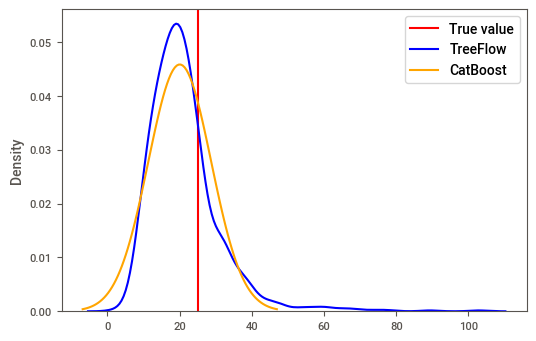

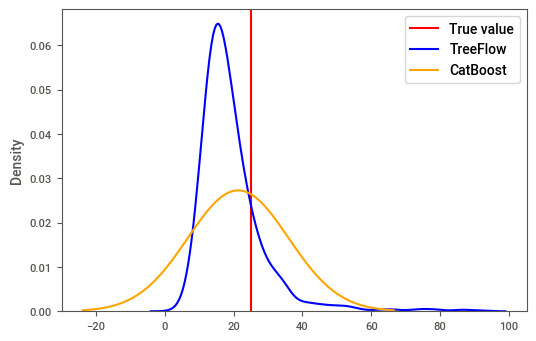

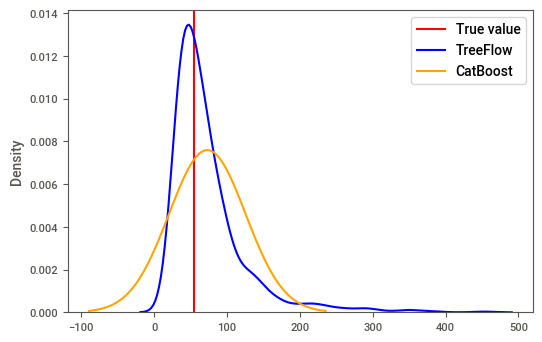

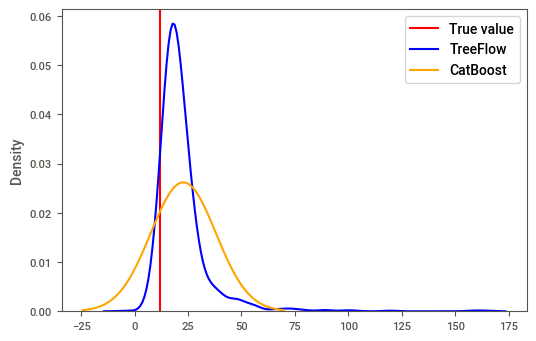

In [19]:
for i in range(10):
    plt.axvline(x=y_test.values[i, :], color='r', label='True value')

    sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

    x = np.linspace(
        stats.norm.ppf(0.001, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        stats.norm.ppf(0.999, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
        100
    )
    plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), color = 'orange', label='CatBoost')

    plt.legend()
    plt.show()

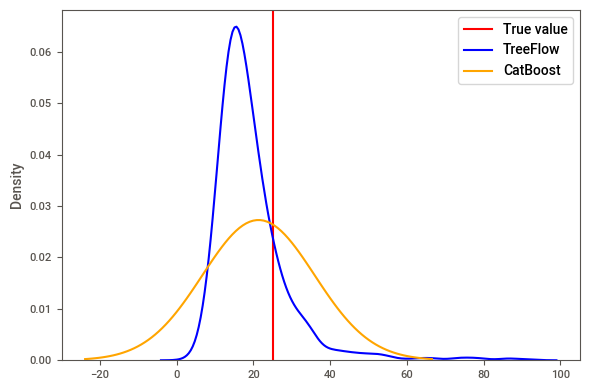

In [21]:
i = 7

plt.axvline(x=y_test.values[i, :], color='r', label='True value')

sns.kdeplot(y_test_samples[i, :], color='blue', label='TreeFlow')

x = np.linspace(
    stats.norm.ppf(0.001, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
    stats.norm.ppf(0.999, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), 
    100
)
plt.plot(x, stats.norm.pdf(x, loc=y_test_catboost[i, 0], scale=np.sqrt(y_test_catboost[i, 1])), color = 'orange', label='CatBoost')

plt.legend()
plt.tight_layout()
plt.savefig('wine_reviews.pdf')